In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.ndimage
from scipy.ndimage import rotate, zoom

In [19]:
PATH = Path('pedestrians')

In [20]:
# I = cv2.imread(str(PATH / 'pos/per00060.ppm'))
# I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

In [21]:
# plt.imshow(I)

In [22]:
def calc_gradient_gray(im):
    dx = scipy.ndimage.convolve1d(np.int32(im), np.array([-1, 0, 1]), axis=1)
    dy = scipy.ndimage.convolve1d(np.int32(im), np.array([-1, 0, 1]), axis=0)

    magnitude = np.sqrt(dx**2 + dy**2)
    orientation = np.arctan2(dy, dx)

    orientation = np.rad2deg(orientation)
    orientation = orientation % 180
    orientation[orientation < 0] += 180

    return magnitude, orientation

In [23]:
def calc_gradient_rgb(im):
    dx = np.stack([scipy.ndimage.convolve1d(np.int32(im[:, :, i]), np.array([-1, 0, 1]), axis=1) for i in range(3)], axis=2)
    dy = np.stack([scipy.ndimage.convolve1d(np.int32(im[:, :, i]), np.array([-1, 0, 1]), axis=0) for i in range(3)], axis=2)

    magnitude = np.sqrt(dx**2 + dy**2)
    
    maxR = (magnitude[:, :, 0] >= magnitude[:, :, 1]) & (magnitude[:, :, 0] >= magnitude[:, :, 2])
    maxG = (magnitude[:, :, 1] > magnitude[:, :, 0]) & (magnitude[:, :, 1] >= magnitude[:, :, 2])
    maxB = (magnitude[:, :, 2] > magnitude[:, :, 0]) & (magnitude[:, :, 2] > magnitude[:, :, 1])

    new_magnitude = np.zeros_like(magnitude[:, :, 0])
    new_magnitude[maxR] = magnitude[maxR, 0]
    new_magnitude[maxG] = magnitude[maxG, 1]
    new_magnitude[maxB] = magnitude[maxB, 2]

    orientation = np.arctan2(dy, dx)
    
    new_orientation = np.zeros_like(orientation[:, :, 0])
    new_orientation[maxR] = np.rad2deg(orientation[maxR, 0])
    new_orientation[maxG] = np.rad2deg(orientation[maxG, 1])
    new_orientation[maxB] = np.rad2deg(orientation[maxB, 2])

    # new_orientation[new_orientation < 0] += 180
    new_orientation = new_orientation % 180

    return new_magnitude, new_orientation

In [24]:
def calc_gradient(im):
    if len(im.shape) == 2:
        return calc_gradient_gray(im)
    else:
        return calc_gradient_rgb(im)

In [25]:
# I_gray = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY)
# magnitude, orientation = calc_gradient(I)
# print(orientation)

In [26]:
def compute_hog(magnitude, orientation, cell_size=8, num_bins=9):
    height, width = magnitude.shape
    YY_cell, XX_cell = height // cell_size, width // cell_size
    
    histogram = np.zeros((YY_cell, XX_cell, num_bins))
    
    bin_width = 180 / num_bins
    bin_centers = np.linspace(bin_width / 2, 180 - bin_width / 2, num_bins)
    
    for i in range(YY_cell):
        for j in range(XX_cell):
            cell_magnitude = magnitude[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size]
            cell_orientation = orientation[i*cell_size:(i+1)*cell_size, j*cell_size:(j+1)*cell_size]
            
            for y in range(cell_size):
                for x in range(cell_size):
                    angle = cell_orientation[y, x]
                    mag = cell_magnitude[y, x]

                    bin_idx = int(angle // bin_width)
                    lower_bin = bin_idx
                    upper_bin = (bin_idx + 1) % num_bins
                    lower_center = bin_centers[lower_bin]
                    upper_center = bin_centers[upper_bin] if bin_idx + 1 < num_bins else 190

                    v_UB = mag * (angle - lower_center) / bin_width
                    v_LB = mag * (upper_center - angle) / bin_width
                    
                    histogram[i, j, lower_bin] += v_LB
                    histogram[i, j, upper_bin] += v_UB
    
    return histogram

# histogram = compute_hog(magnitude, orientation)


In [27]:
# plt.bar(np.arange(9), histogram.sum(axis=0).sum(axis=0))

In [28]:
def HOGpicture(w, bs): # w - histograms, bs - cell size (8) 
    bim1 = np.zeros((bs, bs)) 
    bim1[np.round(bs//2):np.round(bs//2)+1,:] = 1
    bim = np.zeros(bim1.shape+(9,))
    bim[:,:,0] = bim1
    for i in range(0,9): #2:9,
        rotated = rotate(bim1, -i*20, mode='nearest')
        scale = [bim1.shape[0]/rotated.shape[0], bim1.shape[1]/rotated.shape[1]]
        resized = zoom(rotated, scale)
        bim[:,:,i] = resized / 255

    Y,X,Z = w.shape
    w[w < 0] = 0;
    im = np.zeros((bs*Y, bs*X))
    for i in range(Y):
        iisl = (i)*bs
        iisu = (i+1)*bs
        for j in range(X):
            jjsl = j*bs 
            jjsu=(j+1)*bs
            for k in range(9):
                im[iisl:iisu,jjsl:jjsu] += bim[:,:,k] * w[i,j,k]
    return im

# plt.imshow(HOGpicture(histogram, 8), cmap='gray')



In [29]:
def normalize_blocks(histogram, epsilon=1e-5):
    YY_cell, XX_cell, num_bins = histogram.shape
    normalized_hog = []
    
    for j in range(YY_cell - 1):
        for i in range(XX_cell - 1):
            block_hist = np.concatenate((
                histogram[j, i, :],
                histogram[j, i+1, :],
                histogram[j+1, i, :],
                histogram[j+1, i+1, :]
            ))
            norm = np.linalg.norm(block_hist)
            normalized_block = block_hist / np.sqrt(norm**2 + epsilon**2)
            normalized_hog.append(normalized_block)
    
    return np.concatenate(normalized_hog)

# feature_vector = normalize_blocks(histogram)
# feature_vector[:10]

In [30]:
def hog(im):
    magnitude, orientation = calc_gradient(im)
    histogram = compute_hog(magnitude, orientation)
    feature_vector = normalize_blocks(histogram)
    return feature_vector

### Klasyfikator SVM

In [31]:
HOG_data = np.zeros([2*100, 3781], np.float32)  # 3781 to przykładowa liczba cech HOG, może się różnić

for i in range(100):
    IP = cv2.imread(f'train/pos/per{i+1:05d}.ppm')
    IN = cv2.imread(f'train/neg/neg{i+1:05d}.png')
    
    F_pos = hog(IP)
    HOG_data[i, 0] = 1 
    HOG_data[i, 1:] = F_pos
    
    F_neg = hog(IN)
    HOG_data[i+100, 0] = 0 
    HOG_data[i+100, 1:] = F_neg

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
labels = HOG_data[:, 0]
data = HOG_data[:, 1:]

In [ ]:
from sklearn import svm

clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(data, labels)

SVC(kernel='linear')

In [ ]:
from sklearn.metrics import confusion_matrix

lp = clf.predict(data)
cm = confusion_matrix(labels, lp)

# Wyznaczamy współczynniki TP, TN, FP, FN
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

print(f'TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}')
print(f'Accuracy: {(TP + TN) / sum(sum(cm))}')


TP: 100, TN: 100, FP: 0, FN: 0
Accuracy: 1.0


In [ ]:
from sklearn.model_selection import cross_val_score

# Przykładowa kroswalidacja dla różnych wartości C
for C in [0.1, 1, 10, 100]:
    clf = svm.SVC(kernel='linear', C=C)
    scores = cross_val_score(clf, data, labels, cv=5)
    print(f'C={C}, Accuracy: {scores.mean()}')


C=0.1, Accuracy: 1.0
C=1, Accuracy: 1.0
C=10, Accuracy: 1.0
C=100, Accuracy: 1.0


In [ ]:
HOG_data_test = np.zeros([2*100, 3781], np.float32)  # 3781 to przykładowa liczba cech HOG, może się różnić

for i in range(100):
    IP = cv2.imread(f'train/pos/per{i+500:05d}.ppm')
    IN = cv2.imread(f'train/neg/neg{i+500:05d}.png')
    
    F_pos = hog(IP)
    HOG_data_test[i, 0] = 1 
    HOG_data_test[i, 1:] = F_pos
    
    F_neg = hog(IN)
    HOG_data_test[i+100, 0] = 0 
    HOG_data_test[i+100, 1:] = F_neg

In [ ]:
# Przykładowe dane testowe
test_data = HOG_data_test[:, 1:]
test_labels = HOG_data_test[:, 0]

final_clf = svm.SVC(kernel='linear', C=1.0)
final_clf.fit(data, labels)
test_predictions = final_clf.predict(test_data)

test_cm = confusion_matrix(test_labels, test_predictions)
TP_test = test_cm[1, 1]
TN_test = test_cm[0, 0]
FP_test = test_cm[0, 1]
FN_test = test_cm[1, 0]

print(f'TP: {TP_test}, TN: {TN_test}, FP: {FP_test}, FN: {FN_test}')
print(f'Test Accuracy: {(TP_test + TN_test) / sum(sum(test_cm))}')


TP: 96, TN: 100, FP: 0, FN: 4
Test Accuracy: 0.98


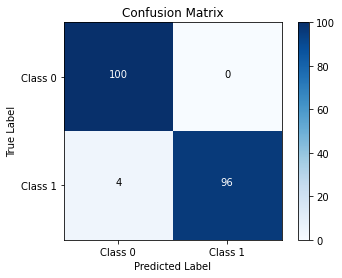

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot confusion matrix
plt.imshow(test_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Class 0', 'Class 1'])
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add labels to each cell
thresh = test_cm.max() / 2.
for i in range(test_cm.shape[0]):
    for j in range(test_cm.shape[1]):
        plt.text(j, i, format(test_cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if test_cm[i, j] > thresh else "black")

plt.show()

### Detekcja sylwetki ludzkiej

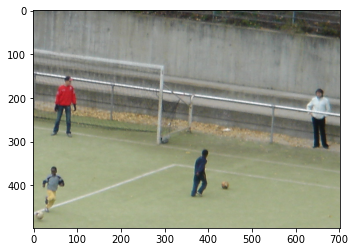

In [ ]:
TEST_PATH = 'test/'
img_1 = cv2.imread(f'{TEST_PATH}testImage1.png')
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
plt.imshow(img_1)

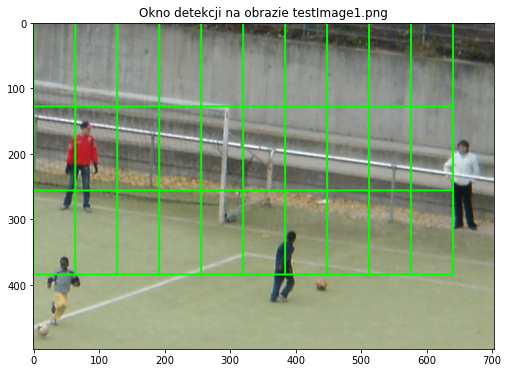

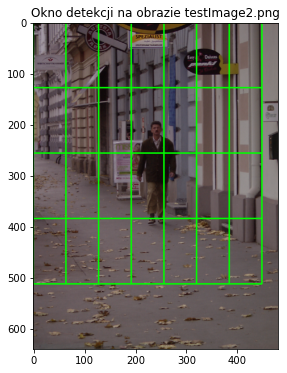

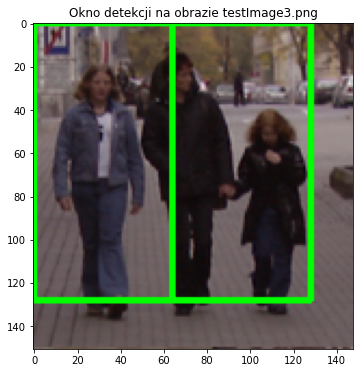

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


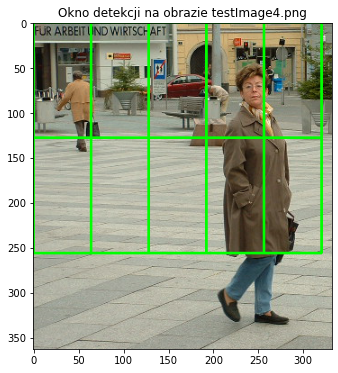

In [ ]:
def draw_detection_window(image, window_size=(64, 128)):
    h, w = image.shape[:2]
    for y in range(0, h - window_size[1], window_size[1]):
        for x in range(0, w - window_size[0], window_size[0]):
            cv2.rectangle(image, (x, y), (x + window_size[0], y + window_size[1]), (0, 255, 0), 2)
    return image

test_images = ['testImage1.png', 'testImage2.png', 'testImage3.png', 'testImage4.png']

for img_path in test_images:
    image = cv2.imread(TEST_PATH + img_path)
    image_with_windows = draw_detection_window(image.copy())

    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image_with_windows, cv2.COLOR_BGR2RGB))
    plt.title(f'Okno detekcji na obrazie {img_path}')
    plt.show()


In [ ]:
def detect(im, resize_scale=1, step=16):
    im_cp = im.copy()
    im_cp = cv2.resize(im_cp, (int(im_cp.shape[1] / resize_scale), int(im_cp.shape[0] / resize_scale)))
    h, w = im_cp.shape[:2]
    sw_h, sw_w = 128, 64
    for y in range(0, h - sw_h, step):
        for x in range(0, w - sw_w, step):
            window = im[y:y+sw_h, x:x+sw_w]
            F = hog(window)
            prediction = final_clf.predict([F])
            if prediction == 1:
                cv2.rectangle(im_cp, (x, y), (x + sw_w, y + sw_h), (0, 255, 0), 2)
    return im_cp


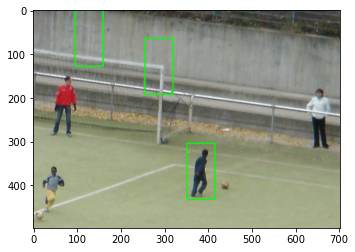

In [ ]:
img_1 = cv2.imread(f'{TEST_PATH}testImage1.png')

plt.imshow(cv2.cvtColor(detect(img_1), cv2.COLOR_BGR2RGB))

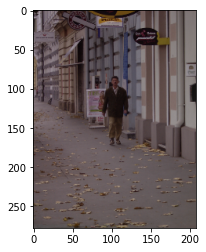

In [ ]:
img_2 = cv2.imread(f'{TEST_PATH}testImage2.png')

plt.imshow(cv2.cvtColor(detect(img_2, resize_scale=2, step= 16), cv2.COLOR_BGR2RGB))

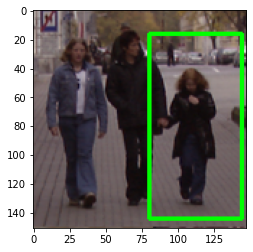

In [ ]:
img_3 = cv2.imread(f'{TEST_PATH}testImage3.png')
plt.imshow(cv2.cvtColor(detect(img_3), cv2.COLOR_BGR2RGB))

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


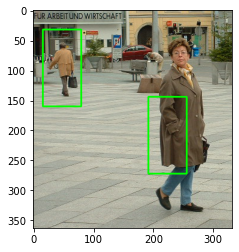

In [ ]:
img_4 = cv2.imread(f'{TEST_PATH}testImage4.png')
img_4 = cv2.cvtColor(img_4, cv2.COLOR_BGR2RGB)
plt.imshow(detect(img_4))

In [ ]:
def detect_pyramid(im, org_img, step=16, scale=1):
    im_cp = im.copy()
    h, w = im_cp.shape[:2]
    sw_h, sw_w = 128, 64
    detectoins = []

    for y in range(0, h - sw_h, step):
        for x in range(0, w - sw_w, step):
            window = im_cp[y:y+sw_h, x:x+sw_w]
            F = hog(window)
            prediction = final_clf.predict([F])
            if prediction == 1:
                x, y = int(x * scale), int(y * scale)
                detectoins.append((x, y, int(sw_w*scale), int(sw_h*scale)))
                # cv2.rectangle(org_img, (x, y), (x + int(sw_w*scale), y + int(sw_h*scale)), (0, 255, 0), 2)
    return detectoins


In [ ]:
def pyramid(image, scale=1.5, min_size=(128, 128)):
    yield image
    while True:
        w = int(image.shape[1] / scale)
        image = cv2.resize(image, (w, int(image.shape[0] / scale)))
        if image.shape[0] < min_size[1] or image.shape[1] < min_size[0]:
            break
        yield image

In [ ]:
def draw_rectangles(image, rects, color=(0, 255, 0), thickness=2):
    for (x, y, w, h) in rects:
        cv2.rectangle(image, (x, y), (x + w, y + h), color, thickness)
    return image

In [ ]:
from imutils.object_detection import non_max_suppression

def detect_person(img, scale=1.5, step=16):
    img_cp = img.copy()
    detections = []
    for i, resized in enumerate(pyramid(img_cp)):
        cur_scale = scale**i
        boxes = detect_pyramid(resized, img, step=step, scale=cur_scale)
        if boxes != []:
            detections.append(boxes)
    detections = np.array([item for sublist in detections for item in sublist])
    pick = non_max_suppression(detections, overlapThresh=0.3)

    final_boxes = []
    for i in range(len(pick)):
        x1, y1, x2, y2 = pick[i]
        inside_other = any((x1 >= x1a and y1 >= y1a and x2 <= x2a and y2 <= y2a) for j, (x1a, y1a, x2a, y2a) in enumerate(pick) if i != j)
        if not inside_other:
            final_boxes.append(pick[i])

    img_cp = draw_rectangles(img_cp, final_boxes)
    return img_cp

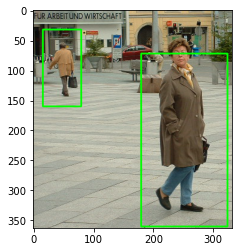

In [ ]:
img_4_cp = detect_person(img_4)
plt.imshow(img_4_cp)

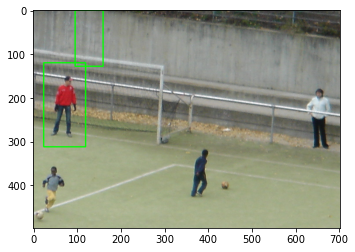

In [ ]:
img_1 = cv2.imread(f'{TEST_PATH}testImage1.png')
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
img_1_cp = detect_person(img_1)
plt.imshow(img_1_cp)

In [ ]:
# img_2 = cv2.imread(f'{TEST_PATH}testImage2.png')
# img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)
# img_2_cp = detect_person(img_2)
# plt.imshow(img_2_cp)

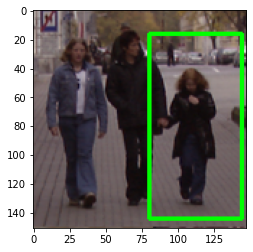

In [ ]:
img_3 = cv2.imread(f'{TEST_PATH}testImage3.png')
img_3 = cv2.cvtColor(img_3, cv2.COLOR_BGR2RGB)
img_3_cp = detect_person(img_3, step=8)
plt.imshow(img_3_cp)